In [39]:
import numpy as np
from ansys.mapdl.core import launch_mapdl
from ansys.mapdl.core.convert import convert_apdl_block
import numpy as np
import pyvista
import matplotlib.pyplot as plt
import pandas as pd

In [43]:
def linear_model(steel_den=7850, steel_poisson=0.3, steel_YM=210e+9, steel_damping=0.01, # material parameters
                   mon_len = 75, mon_base_r2 = 3, mon_base_r1 = 2.973, mon_top_r2 = 3, # monopile parameters
                   mon_top_r1 = 2.973, mon_embedded_n_nodes=5,mon_submerged_n_nodes=3, mon_air_n_nodes = 2, 
                   tower_len = 87.6, tower_top_r2 = 1.935, tower_top_r1 = 1.916, # tower parameters
                   tower_base_r2 = 3, tower_base_r1 = 2.973, tower_n_nodes = 10,
                   nac_mass = 350e+3, nac_height = 4.8, nac_n_nodes = 1, # nacelle parameters
                   water_switch=1, # water modelling switch
                   fixtures_switch=1, # adds density to the tower section to account for fixtures/fittings
                   embedded_len = 45,
                   tower_start = 10,
                   soil_model_switch = 1, soil_k_vec = [2.4e8 / 9], soil_eta = 0.01,
                   spring_len = 10,
                   scour_depth=0,
                   wind_load=2e+6,
                   wave_load=0,
                   ):
    
    if soil_model_switch==1: # only applies to linear models
        embedded_len = embedded_len - scour_depth # update effective embedded length based on scour
        
    submerged_len = mon_len - tower_start - embedded_len
    if submerged_len + embedded_len > mon_len:
        raise Exception("monopile cannot be shorter than submerged length + embedded length")

    mon_n_nodes = mon_embedded_n_nodes + mon_submerged_n_nodes + mon_air_n_nodes # useful quantity

    # nacelle calculations
    vol = nac_mass / steel_den
    nac_rad = np.sqrt((vol/nac_height)/np.pi)
    
    # launch mapdl
    mapdl = launch_mapdl()

    ### Modelling
    mapdl.clear()
    mapdl.prep7()

    ## Material properties
    mapdl.mptemp(1,0) 
    # normal steel
    mapdl.mpdata("EX",1,c1=steel_YM)   
    mapdl.mpdata("PRXY",1,c1=steel_poisson)   
    mapdl.mpdata("DENS",1,c1=steel_den)
    mapdl.mpdata("DMPR",1,c1=steel_damping)
    # submerged steel
    mapdl.mpdata("EX",2,c1=steel_YM)   
    mapdl.mpdata("PRXY",2,c1=steel_poisson)   
    mapdl.mpdata("DENS",2,c1=steel_den + 1030) # added mass method (+ density of sea water)
    mapdl.mpdata("DMPR",2,c1=steel_damping)
    # steel + fixture/fittings
    mapdl.mpdata("EX",3,c1=steel_YM)   
    mapdl.mpdata("PRXY",3,c1=steel_poisson)   
    mapdl.mpdata("DENS",3,c1=steel_den + 650) # nominally 8500kg/m3 ~ + 8%
    mapdl.mpdata("DMPR",3,c1=steel_damping)


    # Create element types
    mapdl.et(1,"BEAM188") # beam element
    mapdl.et(2,"COMBIN14", 0, 0, 0) # linear spring element (linear solution, option 3, 3d longitudinal spring damper)
    mapdl.et(3,"COMBIN39", 0, 0, 0, 1, 0, 1) # non-linear spring element

    ## create keypoints for geometry  
    keypoints = [0, embedded_len, embedded_len + submerged_len, mon_len, 
                 mon_len + tower_len, mon_len + tower_len + nac_height]

    kp_num = 1
    for i in range(len(keypoints)):
        mapdl.k(kp_num, keypoints[i], 0, 0)
        kp_num += 1

    # connect keypoints with lines
    mapdl.lstr(1, 2) # monopile line
    mapdl.lstr(2, 3) # tower line
    mapdl.lstr(3, 4) # nacelle line
    mapdl.lstr(4, 5) # tower line
    mapdl.lstr(5, 6) # nacelle line

    ## cross-sections
    # monopile base
    mapdl.sectype(1, "BEAM", "CTUBE", "monopile", 0)  
    mapdl.secoffset("CENT") 
    mapdl.secdata(mon_base_r1,mon_base_r2,0,0,0,0,0,0,0,0,0,0)  

    # monopile top
    mapdl.sectype(2, "BEAM", "CTUBE", "monopile", 0)  
    mapdl.secoffset("CENT") 
    mapdl.secdata(mon_top_r1,mon_top_r2,0,0,0,0,0,0,0,0,0,0)  

    # tower base
    mapdl.sectype(3, "BEAM", "CTUBE", "tower", 0)  
    mapdl.secoffset("CENT") 
    mapdl.secdata(tower_base_r1,tower_base_r2,0,0,0,0,0,0,0,0,0,0)  

    # tower top
    mapdl.sectype(4, "BEAM", "CTUBE", "tower", 0)  
    mapdl.secoffset("CENT") 
    mapdl.secdata(tower_top_r1,tower_top_r2,0,0,0,0,0,0,0,0,0,0)  

    # monopile taper
    mapdl.sectype(5,"TAPER", name="monopile_taper") 
    mapdl.secdata(1, 0) 
    mapdl.secdata(2, mon_len) 

    # tower taper
    mapdl.sectype(6,"TAPER", name="tower_taper") 
    mapdl.secdata(3, mon_len) 
    mapdl.secdata(4, mon_len + tower_len) 

    # nacelle
    mapdl.sectype(7, "BEAM", "CSOLID", "nacelle", 0)  
    mapdl.secoffset("CENT") 
    mapdl.secdata(nac_rad,0,0,0,0,0,0,0,0,0,0,0)  

    ### ------------- meshing ---------------
    # create keypoint for cross-section orientation
    mapdl.k(7, 0, 20, 0)

    
    ## Meshing line 1 (embedded monopile)
    # set appropriate material
    mapdl.mat(1)
    # select first line
    mapdl.lsel("", "", "", 1)
    # select correct cross section and orientation
    mapdl.latt(1,1,1,7,"",5)
    # Set number of nodes
    mapdl.lesize("ALL", "", "", mon_embedded_n_nodes, "", "", "", "", 1)
    # Mesh line 1
    mapdl.lmesh(1)

    # submerged monopile
    if water_switch == 1:
        mapdl.mat(2)
    mapdl.lsel("", "", "", 2)
    mapdl.latt(1,1,1,7,"",5)
    mapdl.lesize("ALL", "", "", mon_submerged_n_nodes, "", "", "", "", 1)
    mapdl.lmesh(2)

    # monopile in air
    mapdl.mat(1)
    mapdl.lsel("", "", "", 3)
    mapdl.latt(1,1,1,7,"",5)
    mapdl.lesize("ALL", "", "", mon_air_n_nodes, "", "", "", "", 1)
    mapdl.lmesh(3)

    # tower
    if fixtures_switch == 1:
        mapdl.mat(3)
    mapdl.lsel("", "", "", 4)
    mapdl.latt(1,1,1,7,"",6)
    mapdl.lesize("ALL", "", "", tower_n_nodes, "", "", "", "", 1)
    mapdl.lmesh(4)

    # nacelle
    mapdl.mat(2)
    mapdl.lsel("", "", "", 5)
    mapdl.latt(1,1,1,7,"",7)
    mapdl.lesize("ALL", "", "", nac_n_nodes, "", "", "", "", 1)
    mapdl.lmesh(5)

    # Workaround for material selection not working during meshing
    if water_switch:
        mapdl.esel("","","",mon_embedded_n_nodes + 1,mon_embedded_n_nodes + mon_submerged_n_nodes)
        mapdl.mpchg(2,"ALL")
    if fixtures_switch:
        mapdl.esel("","","",mon_n_nodes + 1, mon_n_nodes + tower_n_nodes)
        mapdl.mpchg(3,"ALL") 
    mapdl.esel("ALL")

    # # Springs
    n_springs = mon_embedded_n_nodes + 1 # get appropriate num nodes below soil depth
    spring_gap = embedded_len/mon_embedded_n_nodes # gap between springs (i.e. gap between nodes)
    spring_depths = []
    for i in range(n_springs):
        spring_depths.append(0 + i*spring_gap) # shallowest to deepest

    ### ---------- Soil Modelling -------------

    # Initialise natural frequency array
    pop_size = len(soil_k_vec)

    #nat_freqs = np.zeros((6, pop_size)) # first 6 natural frequencies
    nat_freqs = np.zeros((pop_size,1))

    for p in range(pop_size):
        ## Set up constants

        ## put APDL back in the correct mode
        mapdl.prep7()
        
        # variables to change for population member
        soil_k = soil_k_vec[p]
        
        # encastre
        if soil_model_switch == 0:
            mapdl.dk(1,"ALL",0) # constrains base of tower
        # linear springs
        elif soil_model_switch == 1: 
            mapdl.type(2) # Change to COMBIN14
            mapdl.r(1, soil_k * spring_gap, soil_eta) # convert soil_k per unit length to soil_k
            #mapdl.r(2, soil_k * (spring_gap / 2), soil_eta) # for surface and bottom springs
        # non-linear springs

            ## Create springs if needed
            # set up query
            if p == 0: # only need to create springs for the first population member
                q = mapdl.queries
                    # i.e. if modelling soil (not encastre), create springs
                if soil_model_switch == 1:
                    for i in range(n_springs - 1): # no spring at surface (easier to model scour), hence n_springs-1 and i+1
                        mapdl.real(1) # linear model
                        ## y-direction
                        # create node
                        mapdl.n("", embedded_len - (i+1)*spring_gap, spring_len, 0)
                        # create spring
                        mapdl.e(q.node(embedded_len - (i+1)*spring_gap, 0, 0), q.node(embedded_len - (i+1)*spring_gap, spring_len, 0))
                        ## z-direction
                        # create node
                        mapdl.n("", embedded_len - (i+1)*spring_gap, 0, spring_len)
                        # create spring
                        mapdl.e(q.node(embedded_len - (i+1)*spring_gap, 0, 0), q.node(embedded_len - (i+1)*spring_gap, 0, spring_len))
        
                    ### axial q-z spring
                    # # create node
                    # mapdl.r(n_springs + 1, 3e13, soil_eta) # assumed linear spring for base
                    # mapdl.real(n_springs + 1) # change to correct constant set
                    # mapdl.type(2) # Change to COMBIN14
                    
                    # mapdl.n("", -spring_len, 0, 0)
                    # # create spring
                    # mapdl.e(q.node(0, 0, 0), q.node(-spring_len, 0, 0))

                    # Add node constrains to free end of springs
                    #mapdl.d(q.node(0, spring_len, 0),"ALL",0,"",q.node(spring_depths[0], 0, spring_len))
                    
                    # # with q-z spring
                    # if soil_model_switch==1:
                    #     mapdl.d(q.node(embedded_len - spring_gap, spring_len, 0),"ALL",0,"",q.node(-spring_len, 0, 0)) # first spring to last spring
                    # else:
                    #     mapdl.d(q.node(embedded_len, spring_len, 0),"ALL",0,"",q.node(-spring_len, 0, 0)) # first spring to last spring

                    # without q-z spring
                    if soil_model_switch==1:
                        mapdl.d(q.node(embedded_len - spring_gap, spring_len, 0),"ALL",0,"",q.node(0, 0, spring_len)) # first spring to last spring
                    else:
                        mapdl.d(q.node(embedded_len, spring_len, 0),"ALL",0,"",q.node(0, 0, spring_len)) # first spring to last spring
                    
                    mapdl.dk(1,"UX",0) # zero displacement in x-direction

                    

        ## modal analysis
        mapdl.run("/SOL")
        mapdl.modal_analysis(nmode=20, freqb=0, freqe=10, mxpand=20)

        mapdl.finish()
        mapdl.post1()

        # natural frequencies
        #test = mapdl.post_processing.frequency_values[:6]

        ## original with 6 nat frequencies
        #nat_freqs[:,p] = mapdl.post_processing.frequency_values[:6]
        nat_freqs[p] = mapdl.post_processing.frequency_values[1]

    mapdl.exit()
    return nat_freqs


In [41]:
### NREL 5MW Tower only encastre

linear_model(mon_len = 1e-6,
                   embedded_len = 1e-6,
                   tower_start = 1e-6,
                   soil_model_switch = 0,
                   tower_len=87.6,
                   tower_top_r2 = 1.935, tower_top_r1 = 1.9103, # 30% increase in thickness
                   tower_base_r2 = 3, tower_base_r1 = 2.9649, # 30% increase in thickness
                   ).squeeze()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


array(0.32083)

In [33]:
### Zuo NREL 5MW Tower + monopile, encastre, fixed at seabed

linear_model(mon_len = 35, # to effectively fix it at seabed level
                   embedded_len = 1e-6, # to effectively fix it at seabed level
                   tower_top_r2 = 1.935, tower_top_r1 = 1.9103, # 30% increase in thickness
                   tower_base_r2 = 3, tower_base_r1 = 2.9649,
                   mon_top_r2 = 3, mon_top_r1 = 2.9649, # 30% increase in thickness
                   mon_base_r2 = 3, mon_base_r1 = 2.9649,
                   soil_model_switch = 0,
                   ).squeeze() # 30% increase in thickness).squeeze()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


array([0.21498, 0.21498, 1.5536 , 1.5536 , 4.576  , 4.576  ])

In [32]:
### Zuo NREL 5MW Tower + monopile, encastre, fixed at base of monopile
linear_model(      tower_top_r2 = 1.935, tower_top_r1 = 1.9103, # 30% increase in thickness
                   tower_base_r2 = 3, tower_base_r1 = 2.9649,
                   mon_top_r2 = 3, mon_top_r1 = 2.9649, # 30% increase in thickness
                   mon_base_r2 = 3, mon_base_r1 = 2.9649,
                   soil_model_switch = 0,
                   ).squeeze() # 30% increase in thickness).squeeze()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


array([0.14253, 0.14253, 0.93735, 0.93735, 2.7669 , 2.7669 ])

In [36]:
### Zuo NREL 5MW Tower + monopile, springs
linear_model(tower_top_r2 = 1.935, tower_top_r1 = 1.9103, # 30% increase in thickness
                   tower_base_r2 = 3, tower_base_r1 = 2.9649,
                   mon_top_r2 = 3, mon_top_r1 = 2.9649, # 30% increase in thickness
                   mon_base_r2 = 3, mon_base_r1 = 2.9649,
                   soil_model_switch = 1,
                   #soil_k_vec=[1e7], # N/m
                   soil_k_vec=[4e6], # N/m
                   mon_embedded_n_nodes=50,
                   ).squeeze()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


array([0.     , 0.15547, 0.15547, 1.0481 , 1.0481 , 2.9874 ])

In [47]:
soil_k_vec=[2e6, 2.2e6, 2.4e6, 2.6e6, 2.8e6, 3e6, 3.2e6, 3.4e6, 3.6e6, 3.8e6, 4e6, 4.2e6, 4.4e6, 4.6e6, 4.8e6, 5e6, 5.2e6, 5.4e6, 5.6e6, 5.8e6, 6e6]

wn = linear_model(tower_top_r2 = 1.935, tower_top_r1 = 1.9103, # 30% increase in thickness
                   tower_base_r2 = 3, tower_base_r1 = 2.9649,
                   mon_top_r2 = 3, mon_top_r1 = 2.9649, # 30% increase in thickness
                   mon_base_r2 = 3, mon_base_r1 = 2.9649,
                   soil_model_switch = 1,
                   #soil_k_vec=[1e7], # N/m
                   soil_k_vec=soil_k_vec, # N/m
                   mon_embedded_n_nodes=50,
                   ).squeeze()


wn = np.reshape(wn, (-1))

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...


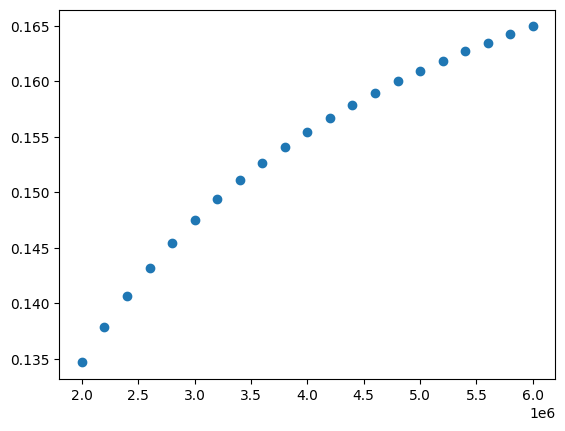

In [48]:
plt.scatter([2e6, 2.2e6, 2.4e6, 2.6e6, 2.8e6, 3e6, 3.2e6, 3.4e6, 3.6e6, 3.8e6, 4e6, 4.2e6, 4.4e6, 4.6e6, 4.8e6, 5e6, 5.2e6, 5.4e6, 5.6e6, 5.8e6, 6e6],wn)

In [50]:
# create dataframe
fe_df = pd.DataFrame(
    { 'k': soil_k_vec,
     'wn': wn
    })

fe_df.head()

fe_df.to_csv('fe_model_data/fe_model_data.csv')